In [1]:
%pip install pyspark==3.1.1 pyarrow tldextract

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
sys.executable

'/usr/local/anaconda3/envs/ada/bin/python'

In [3]:
# Make sure that spark uses the same python distribution to avoid serialization issues due to missing packages
%env PYSPARK_PYTHON=/usr/local/anaconda3/envs/ada/bin/python
%env PYSPARK_DRIVER_PYTHON=/usr/local/anaconda3/envs/ada/bin/python

env: PYSPARK_PYTHON=/usr/local/anaconda3/envs/ada/bin/python
env: PYSPARK_DRIVER_PYTHON=/usr/local/anaconda3/envs/ada/bin/python


In [4]:
# Data handling and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# PySpark
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType, BooleanType, ArrayType, StringType, DoubleType

# Helpers
import os
import json

# External libraries
import profanity_check
import tldextract

In [5]:
conf = pyspark.SparkConf().setMaster("local[*]").setAll([
    ('spark.driver.memory','8G'),
    ('spark.driver.maxResultSize', '8G'),
    ('spark.sql.execution.arrow.pyspark.enabled', True),
    ('spark.sql.execution.arrow.maxRecordsPerBatch', 10000),
    ('spark.local.dir', '/tmp')
])

spark = SparkSession.builder.config(conf=conf).config('spark.jars.packages', 'com.johnsnowlabs.nlp:spark-nlp_2.12:3.3.2').getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')
spark

21/11/12 16:53:28 WARN Utils: Your hostname, Dewminis-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.22.22.63 instead (on interface en0)
21/11/12 16:53:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/usr/local/anaconda3/envs/ada/lib/python3.8/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/MDS/.ivy2/cache
The jars for the packages stored in: /Users/MDS/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-95e3b469-6993-43d6-8b35-572718874634;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;3.3.2 in central
	found com.typesafe#config;1.4.1 in central
	found org.rocksdb#rocksdbjni;6.5.3 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.603 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1

In [6]:
DATA_DIR    = 'data/'
QB_DATA_DIR = DATA_DIR + 'quotebank_data/'

QB_DATA_JSON_PATH     = QB_DATA_DIR + 'json/quotes-%s.json'
QB_DATA_JSON_BZ2_PATH = QB_DATA_DIR + 'json/quotes-%s.json.bz2'
QB_DATA_PARQUET_PATH  = QB_DATA_DIR + 'parquet/quotes-%s.parquet'
QB_DATA_PROC_PATH     = QB_DATA_DIR + 'processed/quotes-%s.parquet' # contains qb data with profanity scores, tlds, prominent speaker qid, prominent speaker prob, prominent speaker label

SPK_ATTR_PATH             = DATA_DIR + 'speaker_attributes.parquet'
SPK_ATTR_WITH_LABELS_PATH = DATA_DIR + 'speaker_attributes_with_labels.parquet'

LABELS_PATH = DATA_DIR + 'wikidata_labels_descriptions_quotebank.csv.bz2'

YEARS = ['2020']

In [7]:
QB_JSON_SCHEMA = StructType.fromJson(json.loads(
    '''{  "type": "struct", 
        "fields": [
            {"name": "date", "type": "string", "nullable": true, "metadata": {}}, 
            {"name": "numOccurrences", "type": "long", "nullable": true,"metadata": {}}, 
            {"name": "phase", "type": "string", "nullable": true, "metadata": {}}, 
            {"name": "probas", "type": 
            {"type": "array", "elementType": {"type": "array", "elementType": "string", "containsNull": true}, "containsNull": true}, "nullable": true, "metadata": {}}, 
            {"name": "qids", "type": {"type": "array", "elementType": "string", "containsNull": true}, "nullable": true, "metadata": {}}, 
            {"name": "quotation", "type": "string", "nullable": true, "metadata": {}}, 
            {"name": "quoteID", "type": "string", "nullable": true, "metadata": {}}, 
            {"name": "speaker", "type": "string", "nullable": true, "metadata": {}}, 
            {"name": "urls", "type": {"type": "array", "elementType": "string", "containsNull": true}, "nullable": true, "metadata": {}}
            ]
    }'''))

### Load the labels of QIDS

In [225]:
labels = pd.read_csv(LABELS_PATH)
labels = labels.set_index("QID")

# Analysis of Speaker Attributes

We are given a dataset on all speakers whose quotes appear in the qutoebank data from 2015-2020. In the following, we do a general analysis of this dataset.

In [9]:
spk_attr = spark.read.parquet(SPK_ATTR_PATH)
", ".join(spk_attr.columns)

'aliases, date_of_birth, nationality, gender, lastrevid, ethnic_group, US_congress_bio_ID, occupation, party, academic_degree, id, label, candidacy, type, religion'

In [10]:
spk_attr.count()

9055981

In [11]:
spk_summary = pd.DataFrame( { 'non_null_count' : [ spk_attr.where(spk_attr[col].isNotNull()).count() for col in spk_attr.columns ] }, index=spk_attr.columns )
spk_summary

,non_null_count
aliases,1203402
date_of_birth,5017333
nationality,3715852
gender,7105600
lastrevid,9055981
ethnic_group,130385
US_congress_bio_ID,12874
occupation,6373084
party,399176
academic_degree,99995


We have speakr attributes provided for 9055981 many speakers, and following fields of data are provided:
1. aliases
2. date_of_birth
3. nationality
4. gender
5. lastrevid
6. ethnic_group
7. US_congress_bio_ID
8. occupation
8. party
9. academic_degree.
10. id
11. label, 
12. candidacy
13. type
14. religion

For the fields, 'nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion', the provided data are in terms of the wiki-data identifiers. So we first extend the dataset by addinng new columns with the human readable labels, using the labels dataset.
We save the new augmented data set in *parquet* format.

In [12]:
def qids_to_attr_labels(qids):
    if qids is None or len(qids) == 0:
        return []
    return list(map(lambda qid : labels.Label[qid] if qid in labels.index else qid, qids))

In [13]:
def map_missing(iterator):
    for df in iterator:
        for col in ['nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion']:
            df[col + '_labels'] = df[col].apply(qids_to_attrib_labels)
        yield df

In [14]:
def expand_spk_attr_with_labels():
    spk_attr = spark.read.parquet(SPK_ATTR_PATH)
    for col in ['nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion']:
        spk_attr = spk_attr.withColumn(col + '_labels', spk_attr[col])
    spk_attr.write.parquet(SPK_ATTR_WITH_LABELS_PATH, 'overwrite')

In [15]:
# Uncomment for the first-run to save the processed files
# expand_spk_attr_with_labels()

In [16]:
# Load expanded data
spk_attr = spark.read.parquet(SPK_ATTR_WITH_LABELS_PATH)

# Analysis of Quotebank Data

In [17]:
qb_raw = spark.read.parquet(QB_DATA_PARQUET_PATH % YEARS[0])
for y in YEARS[1:]:
    qb = qb.union(spark.read_parquet(QB_DATA_PARQUET_PATH % y))

In [18]:
", ".join(qb_raw.columns)

'date, numOccurrences, phase, probas, qids, quotation, quoteID, speaker, urls'

In [23]:
@f.udf(returnType=BooleanType())
def is_not_none_or_not_empty(val):
    if val is None:
        return False
    if val == "None":
        return False
    return True

In [24]:
qb_summary = pd.DataFrame( { 'non_null_count' : [ qb_raw.where(is_not_none_or_not_empty(col)).count() for col in qb_raw.columns ] }, index=qb_raw.columns )
qb_summary

,non_null_count
date,5244449
numOccurrences,5244449
phase,5244449
probas,5244449
qids,5244449
quotation,5244449
quoteID,5244449
speaker,3443605
urls,5244449


### Expand the quotebank data with top-level-domains, profanity-scores, etc. and save for eaiser loading in the future

In [40]:
def url_list_to_tlds(urls):
    if urls is None or len(urls) == 0:
        return None
    res = list(map(lambda url : tldextract.extract(url).domain, urls))
    return res if res else None

In [39]:
def fill_columns(iterator):
    for df in iterator:
        df['profanity'] = profanity_check.predict_prob(df.quotation)
        df['speaker_qid'] = df['qids'].apply(lambda qids : None if (qids is None or len(qids) == 0) else qids[0])         
        df['speaker_label'] = df['qids'].apply(lambda qids : None if (qids is None or len(qids) == 0) else (labels.Label[qids[0]] if qids[0] in labels.index else None))
        df['tlds'] = df['urls'].apply(url_list_to_tlds)
        df['speaker_prob'] = df['probas'].apply(lambda p : 0.0 if (p is None or len(p) == 0) else float(p[0][1]))
        yield df

In [38]:
def prepare_data(df):    
    df = df.withColumn('speaker_qid', f.lit(None).cast(StringType()))
    df = df.withColumn('speaker_label', f.lit(None).cast(StringType()))
    df = df.withColumn('speaker_prob', f.lit(None).cast(DoubleType()))
    df = df.withColumn('tlds', df.urls)
    df = df.withColumn('profanity', f.lit(None).cast(DoubleType()))
    df = df.mapInPandas(fill_columns, schema = df.schema)
    return df

In [37]:
def prepare_data_for_years(years, type='json'):
    for y in years:
        if type == 'json':
            df = spark.read.json(QB_DATA_JSON_PATH % y, schema=QB_JSON_SCHEMA)
        elif type == 'parquet':
            df = spark.read.parquet(QB_DATA_PARQUET_PATH % y)
        else:
            break
        df = prepare_data(df)
        df.write.parquet(QB_DATA_PROC_PATH % y, 'overwrite')

In [25]:
# Uncomment for the first-run to save the processed files
# prepare_data_for_years(['2019'], type='parquet')

In [26]:
qb = spark.read.parquet(QB_DATA_PROC_PATH % YEARS[0])
for y in YEARS[1:]:
    qb = qb.union(spark.read_parquet(QB_DATA_PROC_PATH % y))

### Top news domains with high profanity quotes

In [54]:
def profanity_by_news_outlet(df, min_quotes = 10000):
    return df \
        .withColumn('tld', f.explode('tlds')) \
        .groupby('tld') \
        .agg(f.avg('profanity').alias('avg_profanity'), f.count('quotation').alias('count')) \
        .where(f.col('count') >= min_quotes) \
        .sort('avg_profanity', ascending=False)

In [55]:
profanity_by_news_outlet(qb, 10000).show()

+------------------+-------------------+-----+
|               tld|      avg_profanity|count|
+------------------+-------------------+-----+
|               nme|0.12396075646092378|10657|
|thehollywoodgossip| 0.1010810278703445|12271|
|         inquisitr|0.09300202883093707|23046|
|           eonline|0.08896868517040082|11800|
|     thedailybeast|0.08871525342695481|13377|
|        cheatsheet|0.08829257405797264|29177|
|          etcanada|0.08813149158649779|10862|
|            thesun|0.08797538194233366|35166|
|        usmagazine|0.08560456494210512|13111|
|            people|0.08506631683579856|26263|
|              vice|0.08398846484226385|12531|
|       femalefirst|0.08353762173273721|13719|
|         wordpress|0.08251095076109365|21260|
|            mirror|0.08032704952593808|46170|
|         billboard|0.08022228466629261|15511|
|         dailystar|0.08013808967264716|29499|
|       irishmirror|0.07977294491611693|29566|
| hollywoodreporter|0.07638583168069987|11697|
|            

### Quote distribution by profession

In [59]:
def plot_info(title, xlabel, ylabel):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [109]:
def demographic_stats(qb, colname):
    stats = qb.where(qb.speaker_qid.isNotNull()) \
    .join(spk_attr.withColumnRenamed('id', 'speaker_qid'), on='speaker_qid') \
    .withColumn(colname, f.explode(colname + '_labels')) \
    .groupby(colname) \
    .agg(f.count('quotation').alias('count')) \
    .sort('count', ascending=False).limit(50).toPandas()
    stats[colname + '_label'] = stats[colname].apply(lambda qid : labels.Label[qid])
    return stats

def plot_demographic(stats, colname):
    plt.figure(figsize=(15,8))
    ax = sns.barplot(y=colname + '_label', x='count', data=stats)
    plot_info('Number of quotes by ' + colname, 'Number of quotes', colname.title())
    return ax

In [154]:
occupation_stats = demographic_stats(qb, 'occupation')

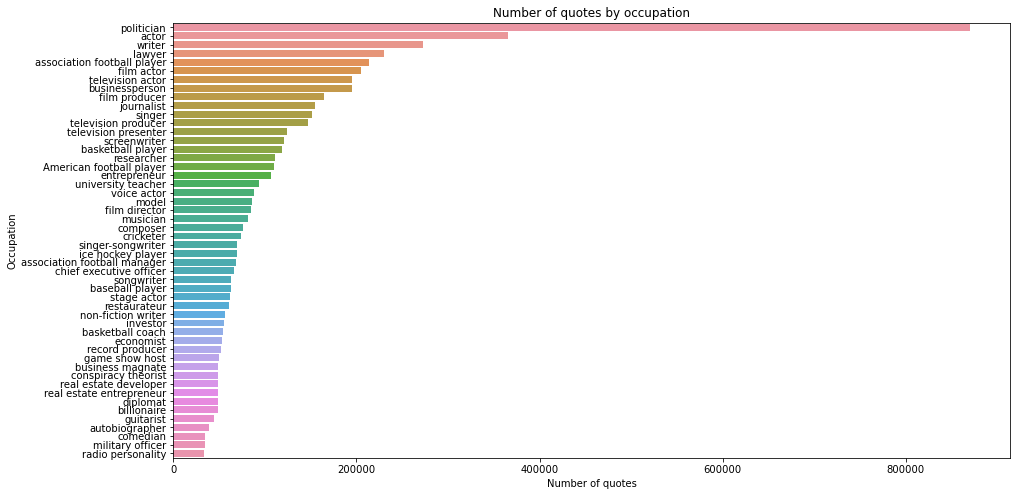

In [155]:
ax = plot_demographic(occupation_stats, 'occupation')

In [80]:
stats = demographic_stats(qb, 'gender')

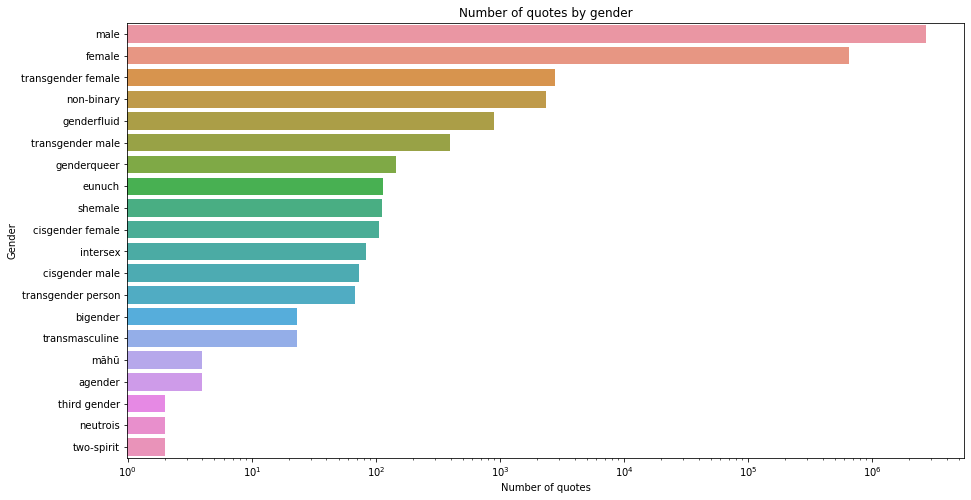

In [82]:
ax = plot_demographic(stats, 'gender')
ax.set_xscale('log')

In [99]:
nationality_stats = demographic_stats(qb, 'nationality')

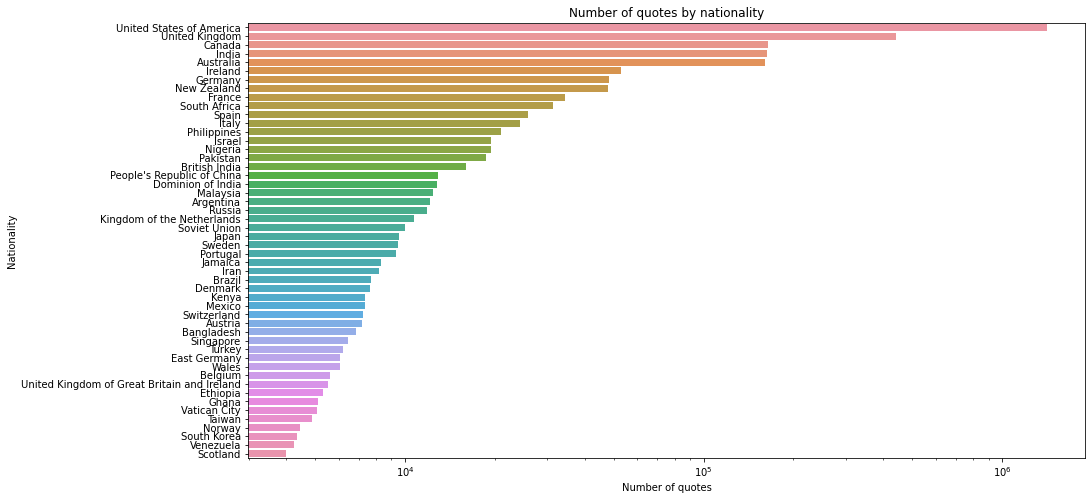

In [100]:
ax = plot_demographic(nationality_stats, 'nationality')
ax.set_xscale('log')

In [101]:
ethnic_group_stats = demographic_stats(qb, 'ethnic_group')

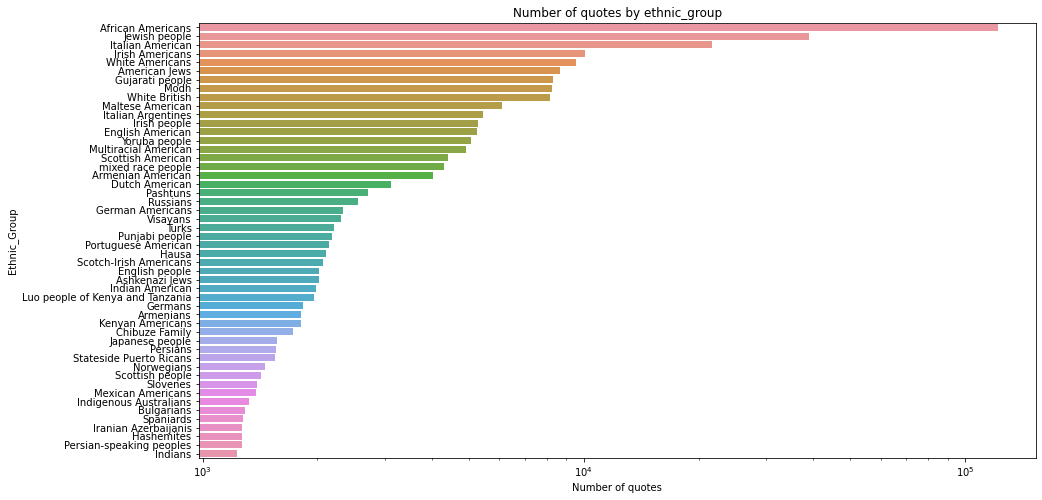

In [102]:
ax = plot_demographic(ethnic_group_stats, 'ethnic_group')
ax.set_xscale('log')

In [103]:
religion_stats = demographic_stats(qb, 'religion')

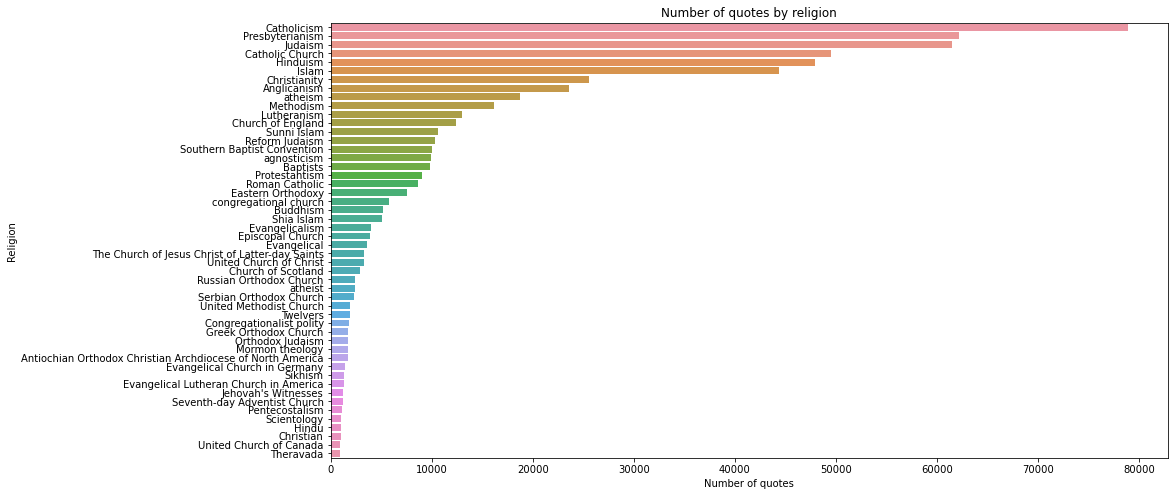

In [105]:
ax = plot_demographic(religion_stats, 'religion')

In [107]:
party_stats = demographic_stats(qb, 'party')

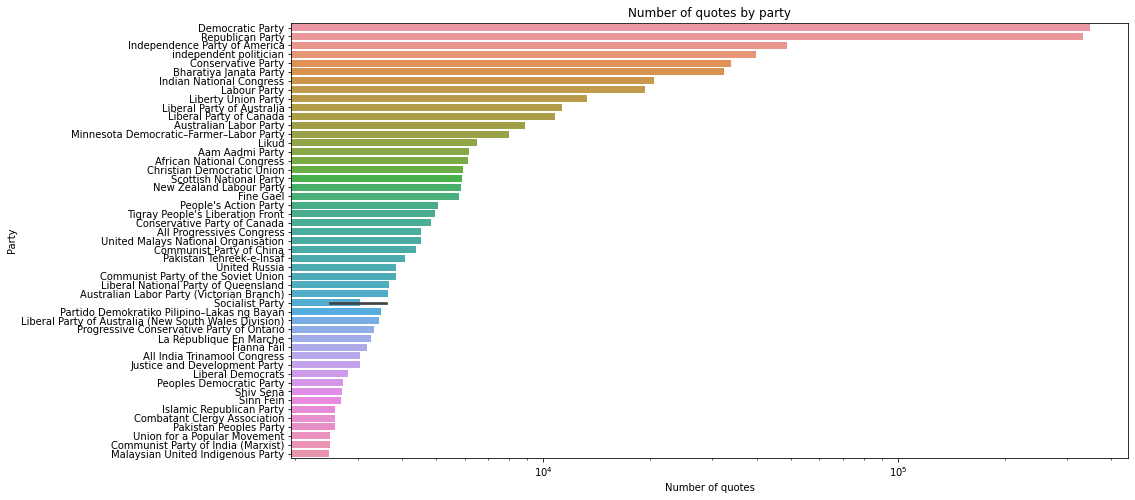

In [117]:
ax = plot_demographic(party_stats, 'party')
ax.set_xscale('log')

In [118]:
academic_degree_stats = demographic_stats(qb, 'academic_degree')

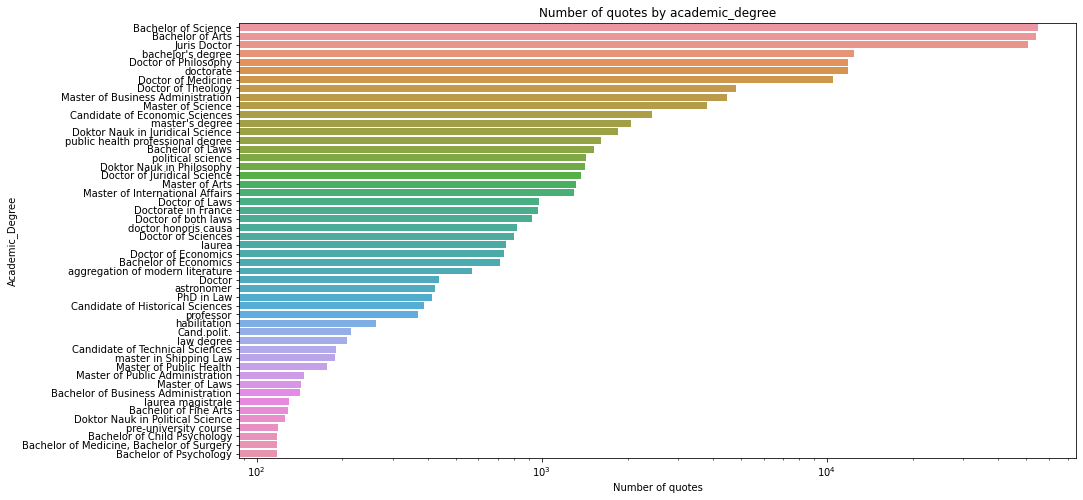

In [120]:
ax = plot_demographic(academic_degree_stats, 'academic_degree')
ax.set_xscale('log')

In [129]:
qb_high_prof = qb.where(qb.profanity > 0.7)

In [130]:
qb_high_prof.count()

30919

In [131]:
occupation_stats_hp = demographic_stats(qb_high_prof, 'occupation')

<AxesSubplot:title={'center':'Number of quotes by occupation'}, xlabel='Number of quotes', ylabel='Occupation'>

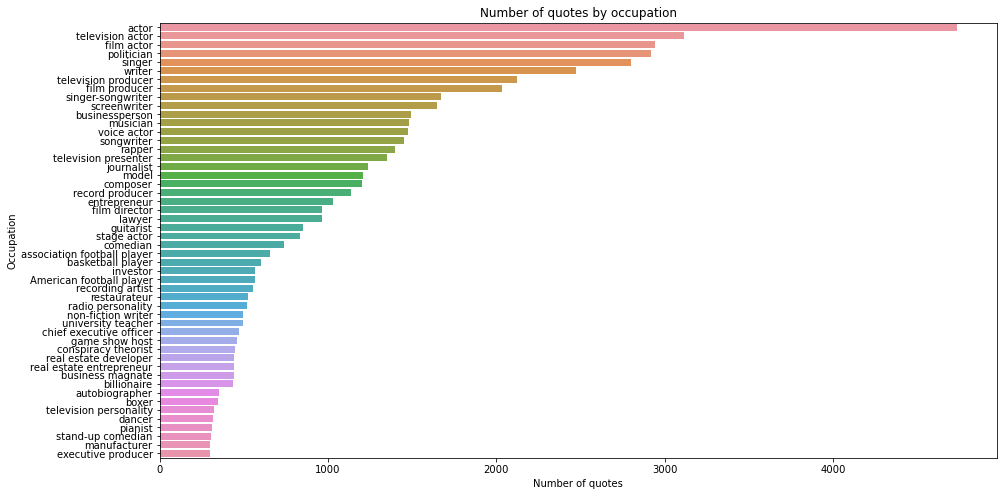

In [132]:
plot_demographic(occupation_stats_hp, 'occupation')

## Quote distribution by the year-of-birth

In [193]:
@f.udf(IntegerType())
def get_year(dob_list):
    return int(dob_list[0][0:5])

In [195]:
qb_yob = qb.where(qb.speaker_qid.isNotNull()) \
    .join(spk_attr.withColumnRenamed('id', 'speaker_qid'), on='speaker_qid') \
    .where(spk_attr.date_of_birth.isNotNull()).withColumn("birth_year", get_year('date_of_birth'))

In [196]:
yob_stats = qb_yob.groupby('birth_year').count().sort('birth_year').toPandas()

<AxesSubplot:xlabel='birth_year'>

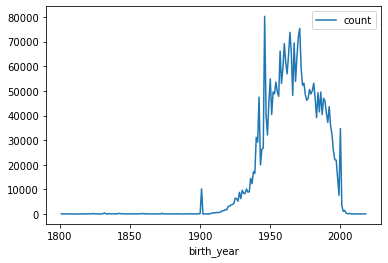

In [200]:
yob_stats[yob_stats.birth_year > 1800].plot.line(x='birth_year', y='count')

In [243]:
top_before_1950 = qb.where(qb.speaker_qid.isNotNull()) \
    .join(spk_attr.withColumnRenamed('id', 'speaker_qid'), on='speaker_qid') \
    .where(spk_attr.date_of_birth.isNotNull()).withColumn("birth_year", get_year('date_of_birth')) \
    .where(f.col('birth_year') < 1950) \
    .groupby('speaker').count().sort('count', ascending=False).toPandas()

In [244]:
top_before_1950

,speaker,count
0,President Donald Trump,28023
1,Bernie Sanders,13189
2,Joe Biden,12817
3,President Trump,12415
4,Elizabeth Warren,7647
...,...,...
37192,Juan Martin,1
37193,Sam Nujoma,1
37194,Louwrien Wijers,1
37195,Dennis Peron,1


In [ ]:
top_after_1990 = qb.where(qb.speaker_qid.isNotNull()) \
    .join(spk_attr.withColumnRenamed('id', 'speaker_qid'), on='speaker_qid') \
    .where(spk_attr.date_of_birth.isNotNull()).withColumn("birth_year", get_year('date_of_birth')) \
    .where(f.col('birth_year') > 1990) \
    .groupby('speaker').count().sort('count', ascending=False).toPandas()

In [240]:
top_after_1990

,speaker,count
0,Justin Bieber,2010
1,Selena Gomez,1628
2,Billie Eilish,1603
3,Demi Lovato,1261
4,Kevin McCarthy,1139
...,...,...
19310,Sabrina Schulz,1
19311,Faith Chepngetich Kipyegon,1
19312,Kojo Funds,1
19313,Joshua Coyne,1


## Comparison of profanity scores in different genders

In [156]:
qb_hp = qb.where(qb.profanity > 0.7)

In [178]:
all_quotes = qb.where(qb.speaker_qid.isNotNull()).count()
hp_quotes = qb_hp.where(qb.speaker_qid.isNotNull()).count()

In [160]:
gender_stats_all = demographic_stats(qb, 'gender')
gender_stats_hp = demographic_stats(qb_hp, 'gender')

In [179]:
gender_stats_all['kind'] = 'all'
gender_stats_all['fraction'] = gender_stats_all['count'] / all_quotes
gender_stats_hp['kind']='high_profanity'
gender_stats_hp['fraction'] = gender_stats_hp['count'] / hp_quotes
gender_stats_cat = pd.concat([gender_stats_all, gender_stats_hp])
gender_stats_cat = gender_stats_cat[gender_stats_cat.fraction > 0.01]
gender_stats_cat

,gender,count,gender_label,kind,fraction
0,Q6581097,2726341,male,all,0.791711
1,Q6581072,648546,female,all,0.188333
0,Q6581097,13780,male,high_profanity,0.735954
1,Q6581072,4630,female,high_profanity,0.247276


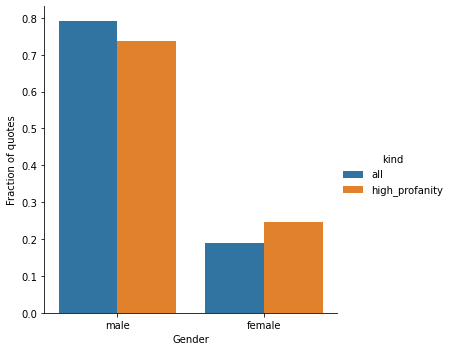

In [181]:
sns.catplot(x='gender_label', y='fraction', hue='kind', kind='bar', data=gender_stats_cat)
plt.xlabel('Gender')
plt.ylabel('Fraction of quotes');

## Temporal Analysis

In [32]:
# Extract the yyyy-mm part from the date
@f.udf(StringType())
def get_month(date_str):
    return "-".join(date_str.split("-")[:2])

@f.udf(StringType())
def get_date(date_str):
    return "-".join(date_str.split("-")[:3])

def normalize(key, pdf):
    return pd.DataFrame({"key": [ key[0] ], "mean" : [ pdf.profanity.mean() ], "sem" : [ pdf.profanity.sem() ]})

Moving average of profanities

In [49]:
daily_avg = qb \
        .withColumn('date', get_date(f.col('quoteID'))) \
        .groupby('date') \
        .applyInPandas(normalize, schema="key string, mean double, sem double") \
        .sort("key") \
        .toPandas()

In [52]:
daily_avg = daily_avg.set_index('key')

In [57]:
mavg = daily_avg.rolling(14).mean()

/usr/local/anaconda3/envs/ada/lib/python3.8/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


<AxesSubplot:xlabel='key'>

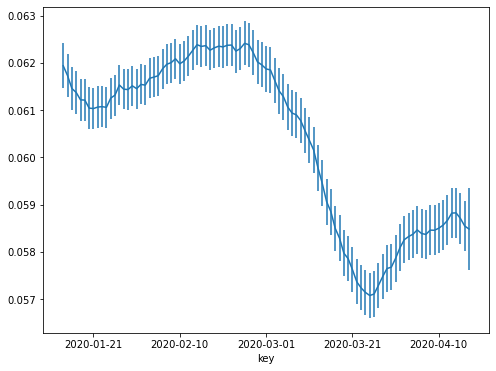

In [58]:
plt.figure(figsize=(8, 6))
mavg['mean'].plot.line(yerr=mavg['sem'])

In [66]:
def plot_distribution(df, title):
    plt.figure(figsize=(6,8))
    plt.ylim(0.99 * df['mean'].min(), 1.01 * df['mean'].max())
    sns.barplot(x=df["key"], y=df["mean"], yerr=1.96*df["sem"])
    plt.xlabel("month")
    plt.ylabel("average profanity with 95% error bars")
    plt.title(title)
    plt.show()

In [67]:
d1 = qb.where(qb.speaker_qid.isNotNull()) \
        .withColumn('date', get_month(f.col('quoteID'))) \
        .groupby('date') \
        .applyInPandas(normalize, schema="key string, mean double, sem double") \
        .sort("key") \
        .toPandas()

In [68]:
d2 = qb.where(qb.speaker_qid.isNotNull()) \
        .withColumn('date', get_month(f.col('quoteID'))) \
        .where( (qb.speaker != "President Donald Trump") \
               & (qb.speaker != "President Trump") \
               & (qb.speaker != "Donald Trump") ) \
        .groupby("date") \
        .applyInPandas(normalize, schema="key string, mean double, sem double") \
        .sort("key") \
        .toPandas()

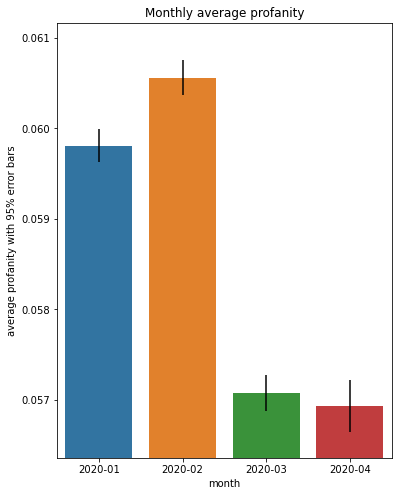

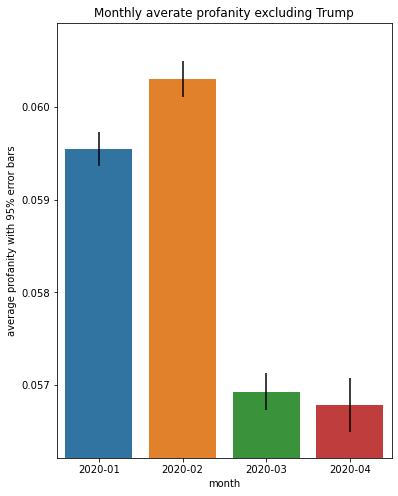

In [69]:
plot_distribution(d1, "Monthly average profanity")
plot_distribution(d2, "Monthly averate profanity excluding Trump")

(0.05621509567879076, 0.06116344827488733)

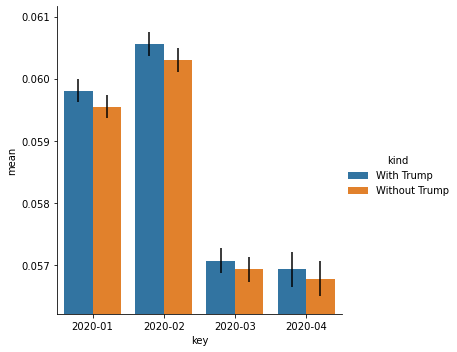

In [70]:
d1['kind'] = 'With Trump'
d2['kind'] = 'Without Trump'
d = pd.concat([d1, d2])
sns.catplot(x='key', y='mean', hue='kind', data=d, kind='bar', yerr=1.96 * d1['sem'])
plt.ylim(0.99 * d['mean'].min(), 1.01 * d['mean'].max())